In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from etcpy import etc
from multiprocessing import Process,cpu_count,Manager
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
particles = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles.pkl','rb')).population

In [3]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [4]:
def format_input(thermalParams):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    params = pd.read_csv('../data/model_enzyme_params.csv',index_col=0)
    new_params = params.copy()
    for key,val in thermalParams.items():
        [ind,col] = key.split('_')
        new_params.loc[ind,col] = val
    
    # Update T90
    new_params['T90'] = params['T90']-params['Tm'] + new_params['Tm']

    df = etc.calculate_thermal_params(new_params)
    return df,new_params

In [5]:
def get_fNT_kcatT_SA(Ts,prot,particles):
    Ts = np.array(Ts)
    
    # 1. fNTs
    fNTs = list()
    kcatTs = list()
    for p in particles:
        df, _ = format_input(p)
        fNTs.append(etc.get_fNT(Ts,df.loc[prot,'dHTH'],df.loc[prot,'dSTS'],df.loc[prot,'dCpu']))
        kcatTs.append(etc.calculate_kcatT(Ts,df.loc[prot,'dHTH'],df.loc[prot,'dSTS'],df.loc[prot,'dCpu'],1,
                                      df.loc[prot,'dCpt'],df.loc[prot,'Topt']))
    
    fNTs = np.array(fNTs)
    kcatTs = np.array(kcatTs)
    SAs = fNTs*kcatTs
    
    return fNTs, kcatTs, SAs

In [30]:
def plot_single_enzyme_temps(Ts,fNTs=None, kcatTs=None, SAs=None, first=False,title=None):
    sns.set_style('ticks')
    Ts = Ts-273.15
    
    colors = '#e78ac3,#7fc97f,#fc8d59'.split(',')
    def _plot(data,label,c,lb=None,ub=None):
        
        y = np.percentile(data,[5,50,95],axis=0)

        plt.plot(Ts,y[1,:],color=c)
        plt.fill_between(Ts,y[0,:],y[2,:],alpha=0.5,color=c)
        ylim = [-0.01,1.03]
            
        plt.ylim(ylim)
        plt.xlim((0,45))
        plt.xlabel('Temperature ($^\circ$C)')
        if first: 
            plt.ylabel('Normalized value')
            plt.yticks(np.arange(0,1.2,0.2))
        if not first: 
            plt.yticks([])
            
        plt.xticks(np.arange(5,50,10),fontsize=8)
        plt.xlim([0,45])
        #plt.title(label)
        #plt.tight_layout()
        #plt.savefig('../figures/{0}_{1}_T.pdf'.format(prot,label))
        #plt.show()
    
    if fNTs is not None: _plot(fNTs,'Denaturation',colors[0],lb=0,ub=1)
    if kcatTs is not None: _plot(kcatTs,'$k_{cat}$',colors[1],lb=0)
    if SAs is not None: _plot(SAs,'Activity',colors[2],lb=0)
    if title is not None: plt.title(title)
    
    #plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Probability in native state')
    #plt.legend()
    #plt.tight_layout()
    #plt.savefig('../figures/{0}_T.pdf'.format(prot))
    #plt.show()

In [7]:
gene_names,gene_ids = load_gene_names()

In [8]:
data = list()
Ts = np.arange(5,100) + 273.15
for gene in ['ERG1','TDH1','TDH2','TDH3','PDC1']:
    uni = gene_ids[gene]
    fNTs, kcatTs, SAs = get_fNT_kcatT_SA(Ts,uni,particles)
    data.append([Ts,fNTs, kcatTs, SAs])

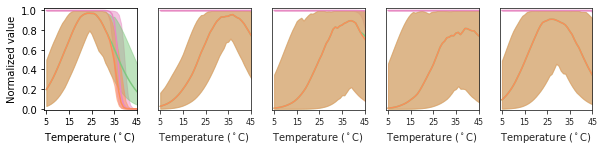

In [9]:
plt.figure(figsize=(8.5,2.2))
for i,lst in enumerate(data):
    plt.subplot(1,5,i+1)
    if i == 0: plot_single_enzyme_temps(*lst,first=True)
    else:  plot_single_enzyme_temps(*lst)
plt.tight_layout()
plt.savefig('../figures/sa_top5.pdf')
plt.show()

In [10]:
data = list()
Ts = np.arange(5,100) + 273.15
for gene in ['ERG1', 'ATP1', 'ALA1', 'KRS1', 'SER1', 'HEM1', 'PDB1', 'ADH1',  'TRP3']:
    uni = gene_ids[gene]
    fNTs, kcatTs, SAs = get_fNT_kcatT_SA(Ts,uni,particles)
    data.append([Ts,fNTs, kcatTs, SAs])

In [29]:
enzymes = ['ERG1', 'ATP1', 'ALA1', 'KRS1', 'SER1', 'HEM1', 'PDB1', 'ADH1',  'TRP3']

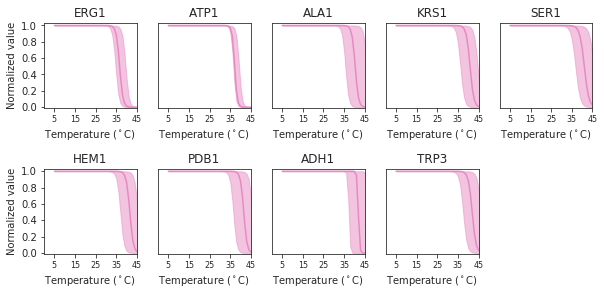

In [35]:
plt.figure(figsize=(8.5,4.2))
for i,lst in enumerate(data):
    plt.subplot(2,5,i+1)
    if i%5 == 0: plot_single_enzyme_temps(lst[0],fNTs=lst[1],first=True,title=enzymes[i])
    else:  plot_single_enzyme_temps(lst[0],fNTs=lst[1],title=enzymes[i])
plt.tight_layout()
plt.savefig('../figures/sa_unstable_9enzymes_denature.pdf')
plt.show()

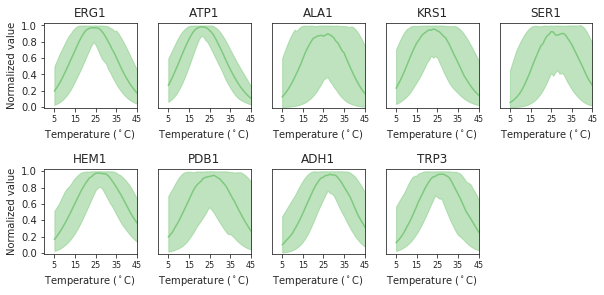

In [36]:
plt.figure(figsize=(8.5,4.2))
for i,lst in enumerate(data):
    plt.subplot(2,5,i+1)
    if i%5 == 0: plot_single_enzyme_temps(lst[0],kcatTs=lst[2],first=True,title=enzymes[i])
    else:  plot_single_enzyme_temps(lst[0],kcatTs=lst[2],title=enzymes[i])
plt.tight_layout()
plt.savefig('../figures/sa_unstable_9enzymes_kcat.pdf')
plt.show()

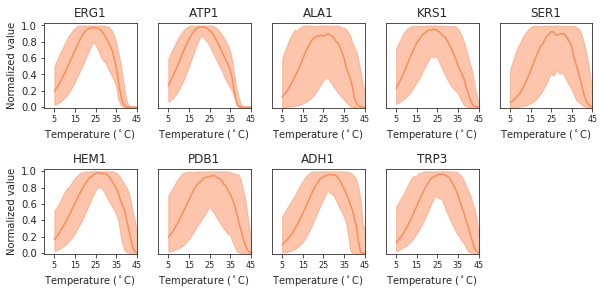

In [37]:
plt.figure(figsize=(8.5,4.2))
for i,lst in enumerate(data):
    plt.subplot(2,5,i+1)
    if i%5 == 0: plot_single_enzyme_temps(lst[0],SAs=lst[3],first=True,title=enzymes[i])
    else:  plot_single_enzyme_temps(lst[0],SAs=lst[3],title=enzymes[i])
plt.tight_layout()
plt.savefig('../figures/sa_unstable_9enzymes_sa.pdf')
plt.show()

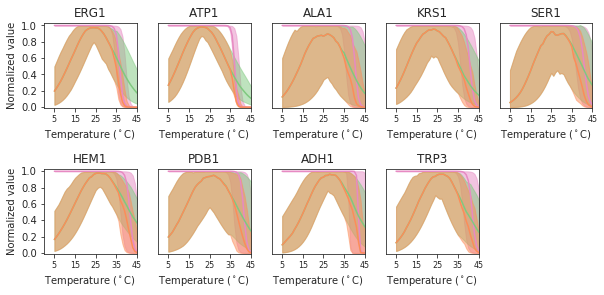

In [38]:
plt.figure(figsize=(8.5,4.2))
for i,lst in enumerate(data):
    plt.subplot(2,5,i+1)
    if i%5 == 0: plot_single_enzyme_temps(*lst,first=True,title=enzymes[i])
    else:  plot_single_enzyme_temps(*lst,title=enzymes[i])
plt.tight_layout()
plt.savefig('../figures/sa_unstable_9enzymes.pdf')
plt.show()

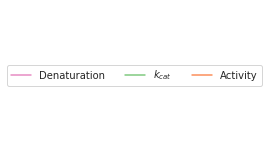

In [74]:
plt.figure(figsize=(3,2.2))
colors = '#e78ac3,#7fc97f,#fc8d59'.split(',')
labls = ['Denaturation','$k_{cat}$','Activity']
for i,lab in enumerate(labls):
    plt.plot([],[],label=lab,color=colors[i])O
plt.axis('off')
plt.legend(loc='center',ncol=3)
plt.tight_layout()
plt.savefig('../figures/sa_top5_legend.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [73]:
?plt.savefig

[-0.04999148043965294, 1.0499995943066502]


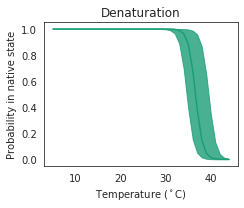

[-0.019713806715984602, 1.048459397283964]


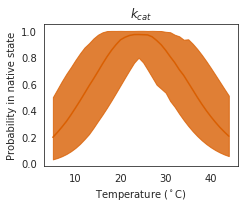

[-0.04999329430390548, 1.0499009738119651]


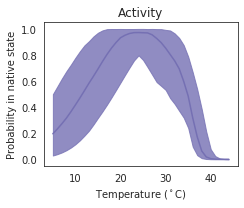

In [7]:
uni = 'P32476'
Ts = np.arange(5,45) + 273.15
fNTs, kcatTs, SAs = get_fNT_kcatT_SA(Ts,uni,particles)
plot_single_enzyme_temps(Ts,fNTs, kcatTs, SAs,uni)